# 01_Library

## install

In [1]:
try:
    import torchtext
except ImportError:
    ! pip install -q torchtext==0.17.0
    import torchtext
! pip install torchmetrics tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.

## import

In [2]:
import os
from collections import Counter
import torchmetrics as tm
import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, random_split

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

----------

# 02_Utils

## system

In [3]:
system= "colab"

if system== "local":
    project_path= r"./"
    dataset_path= './wikitext-2/'

elif system== "colab":
    root_path= '/content/'
    project_path= r"/content/drive/MyDrive/Catalist/1_language modeling/"
    dataset_path= os.path.join(project_path, r'dataset/wikitext-2/')

else:
  raise ValueError("Invalid system")


## device

In [4]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## drive mount

In [5]:
if system== "colab":
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


## number of params fn

In [6]:
def num_trainable_params(model):
  nums= sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

## avragemeter

In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

--------

# 03_Data

In [8]:
class WikiTextDataset:
    def __init__(self, file_path):
        self.file_path= file_path

    def __iter__(self):
        with open(self.file_path, 'r', encoding= 'utf-8') as f:
            for line in f:
                yield line.strip()

train_iter= WikiTextDataset(os.path.join(dataset_path, "wiki.train.tokens"))
valid_iter= WikiTextDataset(os.path.join(dataset_path, "wiki.valid.tokens"))
test_iter= WikiTextDataset(os.path.join(dataset_path, "wiki.test.tokens"))

train_iter_= iter(train_iter)
print(next(train_iter_))
print(next(train_iter_))


= Valkyria Chronicles III =


-------

# 04_Tokenize & Vocab

In [9]:
tokenizer= get_tokenizer('basic_english')
vocab= build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])
torch.save(vocab, 'vocab.pt')
vocab(['amir', 'hi', 'rookie', 'fouladi'])

[0, 9206, 6358, 0]

-----

# 05_EDA

## mean sentence length

In [10]:
total_sentence_count= 0
total_sentence_length= 0

for line in train_iter:
    sentences= line.split('.')

    for sentence in sentences:
        tokens= sentence.strip().split()
        sentence_length= len(tokens)

        if sentence_length >0:
            total_sentence_count +=1
            total_sentence_length +=sentence_length

mean_sentence_length= total_sentence_length/ total_sentence_count

print(f'Mean sentence length in Wikitext-2: {mean_sentence_length:.2f}')

Mean sentence length in Wikitext-2: 21.69


## most common and least common words

In [11]:
freqs= Counter()
for tokens in map(tokenizer, train_iter):
  freqs.update(tokens)

In [12]:
freqs.most_common()[:20]

[('the', 130768),
 (',', 102615),
 ('.', 83397),
 ('of', 57030),
 ('<unk>', 54625),
 ('and', 50735),
 ('in', 45015),
 ('to', 39521),
 ('a', 36523),
 ('=', 29570),
 ('was', 21008),
 ("'", 18484),
 ('@-@', 16906),
 ('on', 15140),
 ('as', 15058),
 ('s', 14936),
 ('that', 14351),
 ('for', 13794),
 ('with', 13012),
 ('by', 12718)]

In [13]:
freqs.most_common()[-20:]

[('yellowwoods', 3),
 ('tomentum', 3),
 ('secretion', 3),
 ('spruces', 3),
 ('lewenthal', 3),
 ('caprices', 3),
 ('étude', 3),
 ('mineurs', 3),
 ('sonatine', 3),
 ('chants', 3),
 ('philipp', 3),
 ('prefaced', 3),
 ('kreutzer', 3),
 ('forrester', 3),
 ('zoromski', 3),
 ('roundabouts', 3),
 ('tuscola', 3),
 ('northeasterly', 3),
 ('intergrades', 3),
 ('gallinae', 3)]

-------

# 06_Preprocessing

In [14]:
def data_process(raw_text_iter, seq_len):
  data= torch.cat([torch.LongTensor(vocab(tokenizer(line))) for line in raw_text_iter])
  M, r= len(data) // seq_len, len(data) % seq_len
  data= torch.cat((data, torch.LongTensor([0]))) if r==0 else data

  inputs= data[:M* seq_len].reshape(-1, seq_len)
  targets= data[1: M*seq_len +1].reshape(-1, seq_len)

  return inputs, targets

In [15]:
seq_len= 35
x_train, y_train= data_process(train_iter, seq_len)
x_valid, y_valid= data_process(valid_iter, seq_len)
x_test, y_test= data_process(test_iter, seq_len)

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

(torch.Size([58571, 35]),
 torch.Size([58571, 35]),
 torch.Size([6126, 35]),
 torch.Size([6126, 35]),
 torch.Size([6910, 35]),
 torch.Size([6910, 35]))

-------

# 07_Custom Dataset

In [16]:
class CustomDataset(Dataset):

  def __init__(self, inputs, targets):
    self.inputs= inputs
    self.targets= targets

  def __len__(self):
    return self.inputs.shape[0]

  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]

In [17]:
train_set= CustomDataset(x_train, y_train)
valid_set= CustomDataset(x_valid, y_valid)
test_set= CustomDataset(x_test, y_test)

--------

# 08_DataLoader

In [ ]:
batch_size= 20
train_loader= DataLoader(train_set, batch_size= batch_size, shuffle= True)
valid_loader= DataLoader(valid_set, batch_size= 2*batch_size, shuffle= False)
test_loader= DataLoader(test_set, batch_size= 2*batch_size, shuffle= False)

print("train batch size:",train_loader.batch_size,
     ", num of batch:", len(train_loader))
print("valid batch size:",valid_loader.batch_size,
     ", num of batch:", len(valid_loader))
print("test batch size:",test_loader.batch_size,
     ", num of batch:", len(test_loader))

train batch size: 20 , num of batch: 2929
valid batch size: 40 , num of batch: 154
test batch size: 40 , num of batch: 173


In [ ]:
x_batch, y_batch= next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([20, 35]), torch.Size([20, 35]))

-------

# 09_Model

In [20]:
class LanguageModel(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers,
                dropout_embd= 0.5, dropout_rnn= 0.5):
    super().__init__()
    self.num_layers= num_layers
    self.hidden_dim= hidden_dim
    self.embedding_dim= embedding_dim

    self.embedding= nn.Embedding(vocab_size, embedding_dim)
    self.embedding.weight.data.uniform_(-0.1, 0.1)
    self.dropout= nn.Dropout(p=dropout_embd)

    self.lstm= nn.LSTM(embedding_dim, hidden_dim, num_layers= num_layers,
                        dropout= dropout_rnn, batch_first= True)

    self.fc= nn.Linear(hidden_dim, vocab_size)

  def forward(self, src):
    embedding= self.dropout(self.embedding(src))
    output, hidden= self.lstm(embedding)
    prediction= self.fc(output)
    return prediction

In [ ]:
model= LanguageModel(vocab_size= len(vocab), embedding_dim= 300,
                     hidden_dim= 512, num_layers= 2,
                     dropout_embd= 0.65, dropout_rnn= 0.5)
model

LanguageModel(
  (embedding): Embedding(28782, 300)
  (dropout): Dropout(p=0.65, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=512, out_features=28782, bias=True)
)

In [ ]:
print(num_trainable_params(model))
print(num_trainable_params(model.embedding))
print(num_trainable_params(model.lstm))
print(num_trainable_params(model.fc))

27.168086
8.6346
3.76832
14.765166


----------

# 10_Config

In [ ]:
vocab_size= len(vocab)
embedding_dim= 300
hidden_dim= 512
num_layers= 2
dropout_embd= 0.5
dropout_rnn= 0.2

model= LanguageModel(vocab_size, embedding_dim,
                     hidden_dim, num_layers,
                     dropout_embd, dropout_rnn).to(device)

In [ ]:
optimizer= optim.SGD(model.parameters(), lr= 0.5,
                     weight_decay= 0, momentum= 0.9,
                     nesterov= True)

loss_fn= nn.CrossEntropyLoss()
metric= tm.text.Perplexity().to(device)

-------------

# 11_One epoch fn

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch= None):
  model.train()
  loss_train= AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit= 'batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs= inputs.to(device)
      targets= targets.to(device)
      outputs= model(inputs)
      loss= loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

      loss.backward()
      nn.utils.clip_grad.clip_grad_norm_(model.parameters(), max_norm= 0.25)
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n= len(targets))
      metric.update(outputs, targets)
      tepoch.set_postfix(loss= loss_train.avg, metric= metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval= AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs= inputs.to(device)
      targets= targets.to(device)
      outputs= model(inputs)

      loss= loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss_eval.update(loss.item(), n= len(targets))
      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

-------

# 12_Experiments before the main training

## base metric

In [ ]:
loss_base, metric_base= evaluate(model, test_loader, loss_fn, metric)
print(f'{loss_base:.2f}, {metric_base:.2f}')

10.28, 29002.41


## overfit on subset of data

In [ ]:
num_epochs= 7
mini_train_size= 1000
mini_batch_size= 20

_, mini_train_dataset= random_split(train_set,
                                   (len(train_set)- mini_train_size,
                                    mini_train_size))
mini_train_loader= DataLoader(mini_train_dataset, mini_batch_size)

model= LanguageModel(vocab_size, embedding_dim,
                     hidden_dim, num_layers,
                     dropout_embd, dropout_rnn).to(device)
optimizer= optim.SGD(model.parameters(), lr= 0.9, momentum= 0.9)

for i in range(num_epochs):
  model, loss_overfit, metric_overfit= train_one_epoch(model, train_loader,
                                                       loss_fn, optimizer,
                                                       metric, epoch= i+1)

Epoch 8:   5%|▌         | 149/2929 [00:05<01:46, 26.00batch/s, loss=4.4, metric=81.4]


KeyboardInterrupt: 

## grid search

In [ ]:
num_epochs= 1
loss_grid= loss_base

for lr in [3, 2, 0.9, 0.3]:
  print(f'LR={lr}')

  model= LanguageModel(len(vocab), embedding_dim= 300,
                       hidden_dim= 512, num_layers= 2,
                       dropout_embd= 0.5, dropout_rnn= 0.2).to(device)
  model= torch.load(f'{project_path}model.pt')
  optimizer= optim.SGD(model.parameters(), lr= lr, weight_decay= 1e-6, momentum= 0.9)

  for epoch in range(num_epochs):
    model, loss, _= train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)
  if loss< loss_grid:
    best_lr= lr
    loss_grid= loss
    print(f'best loss is: {loss_grid} with lr: {best_lr}')
  print()

LR=3


100%|██████████| 2929/2929 [01:54<00:00, 25.69batch/s, loss=4.49, metric=89]


best loss is: 4.488647199866082 with lr: 3

LR=2


100%|██████████| 2929/2929 [01:52<00:00, 25.97batch/s, loss=4.36, metric=78.5]


best loss is: 4.3629220832770255 with lr: 2

LR=0.9


100%|██████████| 2929/2929 [01:52<00:00, 25.95batch/s, loss=4.24, metric=69.7]


best loss is: 4.244371698906121 with lr: 0.9

LR=0.3


100%|██████████| 2929/2929 [01:52<00:00, 25.95batch/s, loss=4.22, metric=68.2]

best loss is: 4.222281780460452 with lr: 0.3



In [ ]:
num_epochs= 2
lr= best_lr

for wd in [0, 1e-6]: #, 1e-5
  print(f'LR={lr}, WD={wd}')

  model= LanguageModel(len(vocab), embedding_dim= 300,
                       hidden_dim= 512, num_layers= 2,
                       dropout_embd= 0.5, dropout_rnn= 0.2).to(device)
  model= torch.load(f'{project_path}model.pt')
  optimizer= optim.SGD(model.parameters(), lr= lr, weight_decay= wd, momentum= 0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)
    loss_valid, metric_valid= evaluate(model, valid_loader, loss_fn, metric)
    print(f'Valid: Loss= {loss_valid:.4}, Metric= {metric_valid:.4}')
  print()

LR=0.3, WD=0


100%|██████████| 2929/2929 [01:49<00:00, 26.68batch/s, loss=4.22, metric=68.2]


Valid: Loss= 4.871, Metric= 130.5


Epoch 1: 100%|██████████| 2929/2929 [01:50<00:00, 26.50batch/s, loss=4.13, metric=61.9]


Valid: Loss= 4.865, Metric= 129.7

LR=0.3, WD=1e-06


100%|██████████| 2929/2929 [01:54<00:00, 25.69batch/s, loss=4.22, metric=68.2]


Valid: Loss= 4.871, Metric= 130.4


Epoch 1: 100%|██████████| 2929/2929 [01:55<00:00, 25.32batch/s, loss=4.13, metric=62]


Valid: Loss= 4.862, Metric= 129.3



---------

# 13_Training

In [ ]:
loss_train_hist, loss_valid_hist= [], []
metric_train_hist, metric_valid_hist= [], []
best_loss_valid= torch.inf
epoch_counter= 0

model= LanguageModel(len(vocab), embedding_dim= 300,
                     hidden_dim= 512, num_layers= 2,
                     dropout_embd= 0.5, dropout_rnn= 0.2).to(device)

In [ ]:
lr, wd= 0.3, 1e-6 #3, 0
model= torch.load(f'{project_path}model.pt')
optimizer= optim.SGD(model.parameters(), lr= lr, weight_decay= wd, momentum= 0.9)

In [ ]:
num_epochs= 7
for epoch in range(1, num_epochs+1):
  model, loss_train, metric_train= train_one_epoch(model, train_loader,
                                                   loss_fn, optimizer,
                                                   metric, epoch)

  loss_valid, metric_valid= evaluate(model, valid_loader,
                                            loss_fn, metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)
  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'{project_path}model.pt')
    best_loss_valid= loss_valid
    print('Model Saved!')

  print(f'Valid: Loss= {loss_valid:.4}, Metric= {metric_valid:.4}')
  print()

  epoch_counter += 1

Epoch 1: 100%|██████████| 2929/2929 [01:56<00:00, 25.11batch/s, loss=4.22, metric=68.2]


Model Saved!
Valid: Loss= 4.869, Metric= 130.2



Epoch 2: 100%|██████████| 2929/2929 [01:56<00:00, 25.14batch/s, loss=4.13, metric=62]


Model Saved!
Valid: Loss= 4.859, Metric= 128.8



Epoch 3: 100%|██████████| 2929/2929 [01:56<00:00, 25.22batch/s, loss=4.08, metric=58.9]


Valid: Loss= 4.86, Metric= 129.0



Epoch 4: 100%|██████████| 2929/2929 [01:54<00:00, 25.61batch/s, loss=4.04, metric=56.6]


Valid: Loss= 4.859, Metric= 129.0



Epoch 5: 100%|██████████| 2929/2929 [01:56<00:00, 25.04batch/s, loss=4, metric=54.7]


Valid: Loss= 4.86, Metric= 129.0



In [ ]:
torch.save(test_loader, f'{project_path}test_loader.pt')

----------

# 14_Learning curve

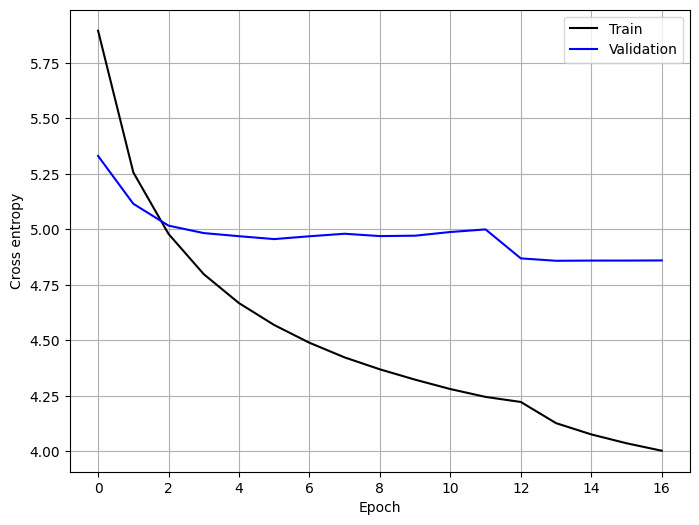

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(len(loss_train_hist)), loss_train_hist, 'k-', label='Train')
plt.plot(range(len(loss_valid_hist)), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Cross entropy')
plt.grid(True)
plt.legend()

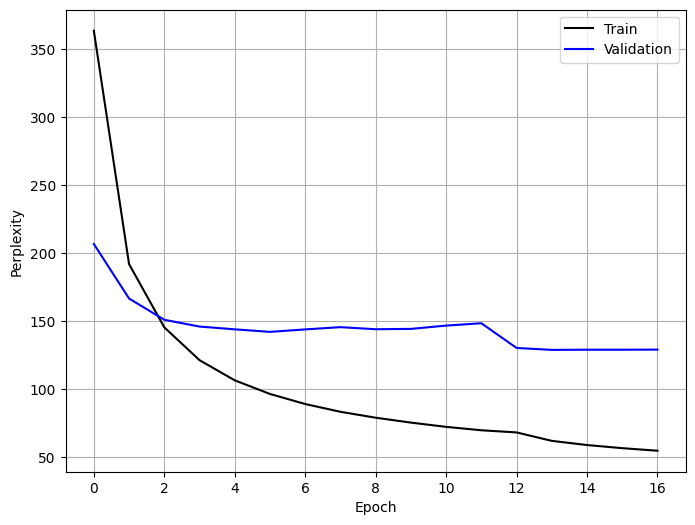

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(len(metric_train_hist)), metric_train_hist, 'k-', label='Train')
plt.plot(range(len(metric_valid_hist)), metric_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.grid(True)
plt.legend()

-------

# 15_Test

In [ ]:
model= torch.load(f'{project_path}model.pt')
model.eval()
with torch.no_grad():
  loss_test, metric_test= evaluate(model, test_loader, loss_fn, metric)
  print(f'Test: Loss= {loss_test:.1f}, Metric= {metric_test:.1f}')

Test: Loss= 4.8, Metric= 122.8


------------

# 16_Text Generator

In [24]:
def generate(prompt, max_seq_len, model, tokenizer, vocab, temperature= 0.5):
  indices= vocab(tokenizer(prompt))
  itos= vocab.get_itos()

  for i in range(max_seq_len):
    with torch.no_grad():
      prediction= model(torch.LongTensor(indices).to(device))

    probs= torch.softmax(prediction[-1]/temperature, dim=0)

    idx= vocab['<ukn>']
    while idx == vocab['<ukn>']:
      idx= torch.multinomial(probs, num_samples= 1).item()

    token= itos[idx]
    prompt +=' ' +token

    if idx == vocab['.']:
      return prompt

    indices.append(idx)

  return prompt

In [25]:
prompt_list= ['In a galaxy far, far away, there', 'The sun was setting in the',
              'Once upon a time, there lived a young princess named',
              'What is the meaning ', 'I\'m not in danger, i am the']

model= torch.load(f'{project_path}models/lstm_model.pt',
                  map_location= device)
model.eval()

for prompt in prompt_list:
  print(generate(prompt, 35, model, tokenizer, vocab))
  print()

In a galaxy far, far away, there were only a few minor alterations in the early stages of the 20th century .

The sun was setting in the original game , but the company ' s main character was not able to focus on the same standards , and that it was a delightful metaphor in the game .

Once upon a time, there lived a young princess named in the middle and the rear is a black @-@ black colour , with the crescent being unable to obtain the right .

What is the meaning  of the word wicca , was published in 1829 by the 15th century .

I'm not in danger, i am the same as well as the most remarkable you , it ' s just a lot of fun .

